# 8. Artificial (Reber) Grammar validator using RNNs

_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

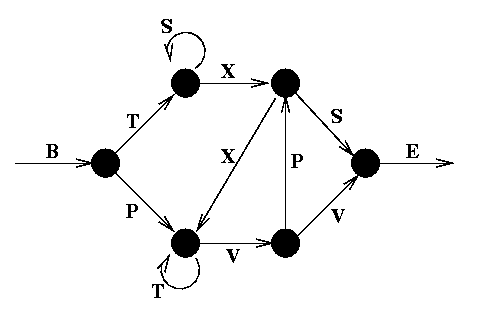

## Prepare environment

In [1]:
import random
import unittest

## Prepare dataset

### Create function to generate Reber grammar text

In [2]:
class ReberGrammarV1:
    grammar_rules = {
        "BT" : ["S", "X"],
        "TS" : ["S", "X"],
        "TX" : ["X", "S"],
        "SS" : ["S", "X"],
        "SX" : ["X", "S"],
        "XX" : ["T", "V"],
        "XT" : ["T", "V"],
        "XV" : ["P", "V"],
        "XS" : ["E"],
        "BP" : ["T", "V"],
        "PT" : ["T", "V"],
        "TT" : ["T", "V"],
        "PV" : ["P", "V"],
        "TV" : ["P", "V"],
        "VV" : ["E"],
        "VP" : ["X", "S"],
        "PS" : ["E"],
        "PX" : ["T", "V"]
    }

    def create_new_text(self):
        # First char
        result = "B"

        # Second char
        result += random.choice(["T", "P"])

        while True:
            last_two_chars = result[-2:]
            next_options = self.grammar_rules.get(last_two_chars)
            if (next_options == None):
                raise Exception(f"Invalid sequence {last_two_chars}")
            next_char = random.choice(next_options)
            result += next_char
            if (next_char == "E"):
                break
        
        return result
    
    def verify(self, text):
        if len(text) < 5:
            raise Exception(f"{text} isn't at least 5 chars long")
        if text[0] != "B":
            raise Exception(f"{text} doesn't start with B")
        if text[1] != "T" and text[1] != "P":
            raise Exception(f"{text} doesn't have T or P as it's second char")
        if text[-1] != "E":
            raise Exception(f"{text} doesn't end with E")
        for index in range(2, len(text)):
            char = text[index]
            two_chars_before = text[index-2:index]
            if (char not in self.grammar_rules.get(two_chars_before)):
                raise Exception(f"{text} is invalid: {char} cannot follow {two_chars_before}")


In [10]:
class ReberGrammarV2:
    grammar_rules = {
        0 : [(1, "B")],
        1 : [(2, "T"), (3, "P")],
        2 : [(2, "S"), (4, "X")],
        3 : [(3, "T"), (5, "V")],
        4 : [(3, "X"), (6, "S")],
        5 : [(4, "P"), (6, "V")],
        6 : [(7, "E")]
    }

    def create_new_text(self):
        result = ""
        state = 0
        while True:
            next_options = self.grammar_rules.get(state)
            if (next_options == None):
                raise Exception(f"Invalid state {state}")
            next_state, next_char = random.choice(next_options)

            result += next_char

            state = next_state
            if (state == 7):
                break
        return result
    
    def verify(self, text):
        state = 0
        for index in range(0, len(text)):
            char = text[index]
            valid = False
            for next_state, next_char in self.grammar_rules.get(state):
                if (char == next_char):
                    state = next_state
                    valid = True
            if not valid:
                raise Exception(f"{text} is not valid: {char} is not a valid option for state {state}")

In [3]:
class TestReberGrammar():

    def test_fail_1(self):
        self.assertRaises(Exception, self.grammar.verify, "BTSSPXSE")
    
    def test_fail_2(self):
        self.assertRaises(Exception, self.grammar.verify, "BPTVVB")
    
    def test_fail_3(self):
        self.assertRaises(Exception, self.grammar.verify, "BTXXVVSE")

    def test_fail_4(self):
        self.assertRaises(Exception, self.grammar.verify, "BPVSPSE")

    def test_fail_5(self):
        self.assertRaises(Exception, self.grammar.verify, "BTSSSE")

    def test_success_1(self):
        self.grammar.verify("BTSSXXTVVE")

    def test_success_2(self):
        self.grammar.verify("BPVVE")

    def test_success_3(self):
        self.grammar.verify("BTXXVPSE")

    def test_success_4(self):
        self.grammar.verify("BPVPXVPXVPXVVE")

    def test_success_5(self):
        self.grammar.verify("BTSXXVPSE")

In [4]:
class TestReberGrammarV1(unittest.TestCase, TestReberGrammar):
    def setUp(self):
        self.grammar = ReberGrammarV1()

In [12]:
class TestReberGrammarV2(unittest.TestCase, TestReberGrammar):
    def setUp(self):
        self.grammar = ReberGrammarV2()

In [ ]:
grammar = ReberGrammarV1()
new_text = grammar.create_new_text()
grammar.verify(new_text)
print(new_text)

BTXSE


In [11]:
grammar = ReberGrammarV2()
new_text = grammar.create_new_text()
grammar.verify(new_text)
print(new_text)

BPVVE


In [13]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_fail_1 (__main__.TestReberGrammarV1.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV1.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV1.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV1.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV1.test_fail_5) ... ok
test_success_1 (__main__.TestReberGrammarV1.test_success_1) ... ok
test_success_2 (__main__.TestReberGrammarV1.test_success_2) ... ok
test_success_3 (__main__.TestReberGrammarV1.test_success_3) ... ok
test_success_4 (__main__.TestReberGrammarV1.test_success_4) ... ok
test_success_5 (__main__.TestReberGrammarV1.test_success_5) ... ok
test_fail_1 (__main__.TestReberGrammarV2.test_fail_1) ... ok
test_fail_2 (__main__.TestReberGrammarV2.test_fail_2) ... ok
test_fail_3 (__main__.TestReberGrammarV2.test_fail_3) ... ok
test_fail_4 (__main__.TestReberGrammarV2.test_fail_4) ... ok
test_fail_5 (__main__.TestReberGrammarV2.test_fail_5) ... ok
test_success_1 (__main__.TestReberGrammarV2.test_succes

In [22]:
def generate_incorrect_sample(max_length):
    incorrect_text = "".join(random.choices("PTS", k=random.randint(1, max_length)))
    return incorrect_text

In [23]:
generate_incorrect_sample(20)

'PSSPTPPTPTPSTTPPTP'

### Generate dataset
50% valid and 50% invalid

In [15]:
num_of_samples = 100
max_length = 20

In [ ]:
reber_grammar = ReberGrammarV2()
correct_samples = [reber_grammar.create_new_text() for _ in range(num_of_samples // 2)]
incorrect_samples = 